In [1]:
!pip install xgboost --upgrade

In [2]:
# Necessary library import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
df = pd.read_csv('/content/malicious_balanced_safe_reduced.csv')
df.shape

(1522380, 60)

In [5]:
features = [col for col in df.columns if col not in ['Attack Type', 'status']]
df = shuffle(df, random_state=42)
X = df[features]
y = df['Attack Type']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# train the xgboost model
xgb = XGBClassifier(n_estimator=150, max_depth=10, random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimator=150,
              n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

In [7]:
feature_importance = pd.DataFrame({"Feature": features, "Importance": xgb.feature_importances_})

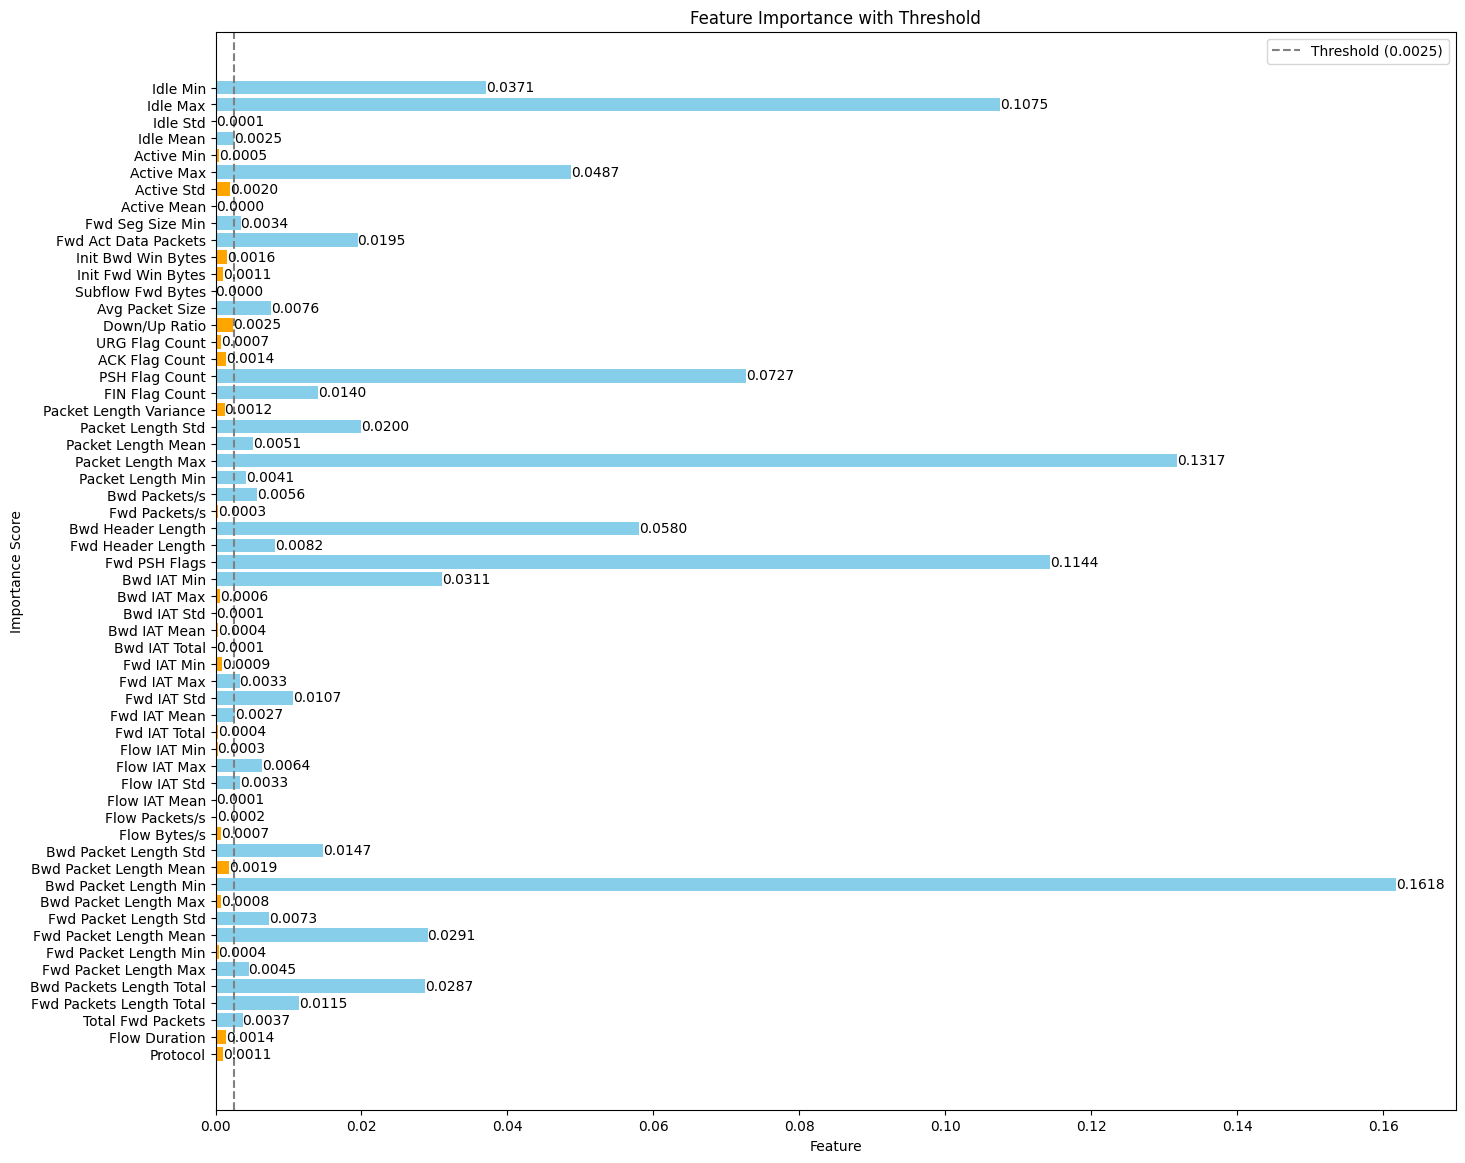

In [8]:
threshold=0.0025
colors = ['skyblue' if imp>=threshold else 'orange' for imp in feature_importance['Importance']]

plt.figure(figsize=(16, 14))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
for bar in bars:
  width = bar.get_width()
  plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

plt.axvline(x=threshold, color='gray', linestyle='--', label=f"Threshold ({threshold})")

plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance with Threshold")
plt.legend()
plt.show()


In [9]:
feature_importance = feature_importance.sort_values('Importance', ascending=False)
top_features = feature_importance['Feature'].iloc[:30].tolist()

# train/test split with selected features
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

In [13]:
%%time
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [150, 200]
}

xgb_clf = XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train)), eval_metric="mlogloss",tree_method='gpu_hist')

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='neg_log_loss', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
CPU times: user 24.7 s, sys: 1.81 s, total: 26.5 s
Wall time: 11min 50s


In [14]:
final_model = XGBClassifier(**best_params, objective='multi:softprob', num_class=len(np.unique(y_train)), eval_metric="mlogloss")
eval_set = [(X_train, y_train), (X_val, y_val)]
final_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

[0]	validation_0-mlogloss:1.63129	validation_1-mlogloss:1.63131
[1]	validation_0-mlogloss:1.40734	validation_1-mlogloss:1.40738
[2]	validation_0-mlogloss:1.23216	validation_1-mlogloss:1.23222
[3]	validation_0-mlogloss:1.09014	validation_1-mlogloss:1.09020
[4]	validation_0-mlogloss:0.97195	validation_1-mlogloss:0.97204
[5]	validation_0-mlogloss:0.87155	validation_1-mlogloss:0.87165
[6]	validation_0-mlogloss:0.78512	validation_1-mlogloss:0.78524
[7]	validation_0-mlogloss:0.70942	validation_1-mlogloss:0.70956
[8]	validation_0-mlogloss:0.64310	validation_1-mlogloss:0.64329
[9]	validation_0-mlogloss:0.58359	validation_1-mlogloss:0.58382
[10]	validation_0-mlogloss:0.53099	validation_1-mlogloss:0.53125
[11]	validation_0-mlogloss:0.48419	validation_1-mlogloss:0.48445
[12]	validation_0-mlogloss:0.44236	validation_1-mlogloss:0.44260
[13]	validation_0-mlogloss:0.40492	validation_1-mlogloss:0.40516
[14]	validation_0-mlogloss:0.37119	validation_1-mlogloss:0.37145
[15]	validation_0-mlogloss:0.34096	

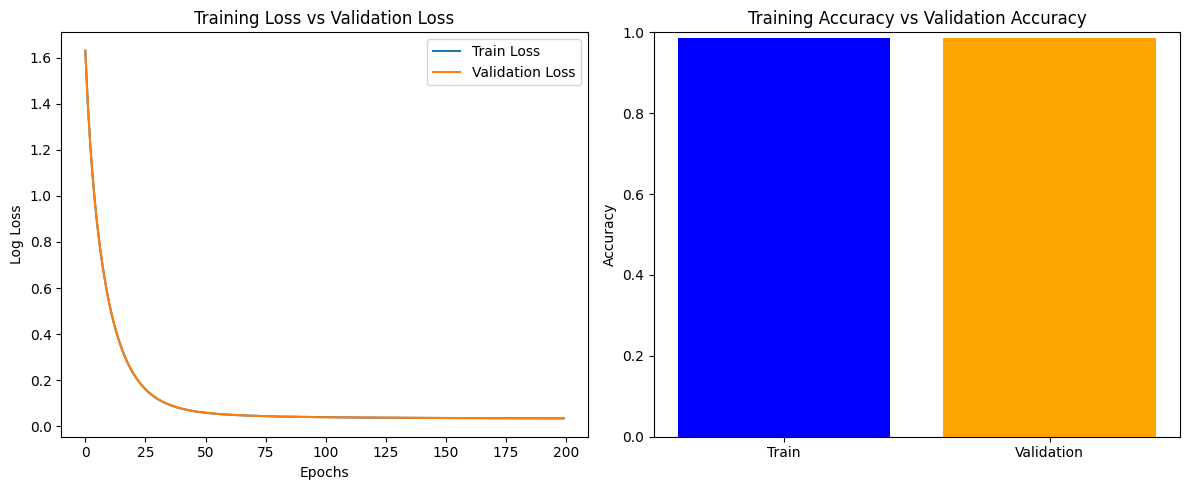

In [15]:
results = final_model.evals_result()

# Plot Training Loss vs Cross-Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['mlogloss'], label='Train Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

# Plot Training Accuracy vs Cross-Validation Accuracy
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Validation'], [train_acc, val_acc], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')

plt.tight_layout()
plt.show()

In [25]:
y_test_pred = final_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     53977
           1       0.97      1.00      0.98     29275
           2       1.00      0.98      0.99     28981
           3       1.00      1.00      1.00     28892
           4       1.00      0.99      0.99     29284
           5       1.00      1.00      1.00     29163
           6       0.97      0.98      0.97     28785

    accuracy                           0.99    228357
   macro avg       0.99      0.99      0.99    228357
weighted avg       0.99      0.99      0.99    228357

[[52279   963    67     5    76     6   581]
 [   24 29251     0     0     0     0     0]
 [  225     0 28431     0     2     0   323]
 [   10     1     0 28877     4     0     0]
 [  149     0     0     2 29078    32    23]
 [   23     0     0     0    10 29034    96]
 [  444     0    43     0     4     3 28291]]


In [26]:
print(train_acc, val_acc, test_acc)

0.9865680241276348 0.9867969889252355 0.9863546990020012
